# Modeling Submissions by Decision Tree, Random Forest and others

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


In [94]:
df = pd.read_csv('./prepared_data.csv')

In [95]:
df['subreddit'].value_counts(normalize=True)

0    0.507132
1    0.492868
Name: subreddit, dtype: float64

In [96]:
df.head()

,num_comments,num_upvotes,subreddit,comment_length,question_length,AUX_comment,NUM_comment,ADV_comment,SCONJ_comment,VERB_comment,...,way,word,work,world,year,Topic0,Topic1,Topic2,Topic3,Topic4
0,3,3,1,184,1970,0.055556,0.055556,0.083333,0.000000,0.111111,...,0.0,0.0,0.0,0.0,0.054868,0.552068,0.055045,0.281612,0.056448,0.054827
1,14,3,0,543,160,0.052632,0.026316,0.078947,0.017544,0.114035,...,0.0,0.0,0.0,0.0,0.000000,0.044244,0.465416,0.044828,0.361178,0.084335
2,55,3,0,83,343,0.047619,0.000000,0.142857,0.000000,0.095238,...,0.0,0.0,0.0,0.0,0.000000,0.060698,0.266193,0.061328,0.163743,0.448038
3,3,0,1,921,185,0.037037,0.010582,0.084656,0.015873,0.121693,...,0.0,0.0,0.0,0.0,0.000000,0.048333,0.749756,0.047386,0.047293,0.107233
4,29,1,0,74,115,0.125000,0.000000,0.125000,0.000000,0.312500,...,0.0,0.0,0.0,0.0,0.000000,0.084430,0.661727,0.085545,0.084678,0.083619


In [97]:
X = df.drop(columns = ['subreddit'])#, 'Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4'

y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [98]:
y.shape

(2664,)

# Decision Tree Classifier

In [99]:
dt = DecisionTreeClassifier(random_state=42, max_depth = 10)

dt.fit(X_train, y_train)
print('Train Score:', dt.score(X_train, y_train))
print('Test Score:', dt.score(X_test, y_test))

Train Score: 0.8163163163163163
Test Score: 0.6471471471471472


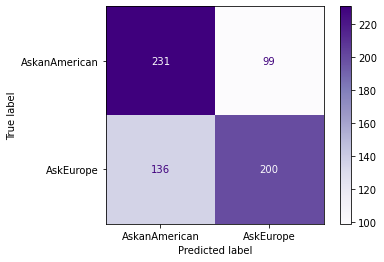

In [100]:
metrics.plot_confusion_matrix(dt, X_test, y_test, cmap='Purples', 
                      values_format='d', display_labels=['AskanAmerican', 'AskEurope']);

In [101]:
preds = dt.predict(X_test)

In [102]:
# Performance by subreddit 

tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds).ravel()

print('Precision:', round(tp/(tp+fp), 2))

print('Recall:', round(tp/(tp + fn),2))

print('Accuracy:',round((tn + tp) / (tn + tp + fn + fp),2))

print('Specificity:',round(tn / (tn + fp),2))

Precision: 0.67
Recall: 0.6
Accuracy: 0.65
Specificity: 0.7


In [103]:
# looking at feature importances 

feature_importance_df = pd.DataFrame({'importance':dt.feature_importances_,
                                                           'features': X.columns})

feature_importance_df.sort_values('importance', ascending = False).head(10)

,importance,features
113,0.109679,state
2,0.095784,comment_length
8,0.080035,VERB_comment
74,0.079003,language
0,0.052646,num_comments
28,0.045412,.
1,0.041659,num_upvotes
3,0.032480,question_length
17,0.030123,PRON_comment
4,0.024181,AUX_comment


**Interpretation**

This model had a variance between test and training scores of almost 20\% indicating that the model overfit on training data and could not perform as well given new data. The features that were the deciding factors were words and comments as well as punctuation use. It also did the poorest at predicting the positive class, 'AskEurope' which may be due to the slight majority (less than 1\%) that the class had. 

In [104]:
#grid searching parameters 
params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params)
grid.fit(X_train, y_train)
 
print(grid.best_params_)
 
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')


{'ccp_alpha': 0, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 10}
Score on training set: 0.7322322322322322
Score on testing set: 0.6381381381381381


In [105]:
pd.DataFrame(grid.cv_results_)[['mean_test_score',
                                'std_test_score']].sort_values('std_test_score')

,mean_test_score,std_test_score
479,0.511011,0.000939
326,0.511011,0.000939
325,0.511011,0.000939
324,0.511011,0.000939
323,0.511011,0.000939
...,...,...
129,0.621615,0.028153
49,0.621615,0.028153
138,0.625619,0.028262
58,0.625619,0.028262


In [106]:
grid_importance_df = pd.DataFrame({'coefs':grid.best_estimator_.feature_importances_,
                                                           'features': X_train.columns})

grid_importance_df.sort_values('coefs', ascending = False).head(10)

,coefs,features
113,0.172453,state
2,0.146616,comment_length
8,0.110472,VERB_comment
74,0.104433,language
28,0.066844,.
0,0.063307,num_comments
3,0.051070,question_length
1,0.029427,num_upvotes
23,0.028302,comment_subjectivity
30,0.025152,?


In [109]:
y_test.shape

(666,)

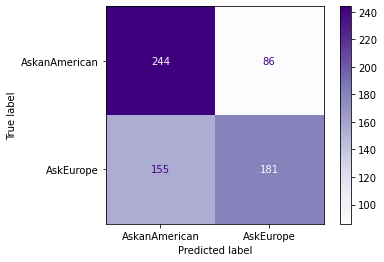

In [110]:
metrics.plot_confusion_matrix(grid, X_test, y_test, cmap='Purples', 
                      values_format='d', display_labels=['AskanAmerican',
                                                         'AskEurope']);

**Interpretation** 

Introducing bias into the Decision Tree Model by decreasing the decisions the tree could make improved the variance of the model from the original attempt. The features used to determine the predictions vary greatly from the logistic regression and could be used for when teachers are looking to focus on certain communication techniques for lesson recommendations as compared to the Logistic Regression model which relied on words in the model.

The model again did better predicting the positive class than the negative one. 

# Random Forest, Bagging and Extra Tree Models

In [111]:
# comparing different models apart from Decision Tree

bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight = 'balanced', 
                            n_estimators = 200,
                            max_depth = 50,
                            max_features = 10,
                            n_jobs = -1)
et = ExtraTreesClassifier(class_weight = 'balanced', n_jobs = -1)
cv = StratifiedKFold(n_splits = 3, random_state = 73, shuffle = True)

def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv = cv)
    print('{} score:\t{} \u00b1 {}'.format(name, s.mean().round(3), 
                                                 s.std().round(3)))
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")

Bagging DT score:	0.659 ± 0.016
Random Forest score:	0.704 ± 0.004
Extra Trees score:	0.686 ± 0.008


In [129]:
# grid searching Random Forest Classifier

params = {
    'n_estimators': [10, 100],
    'max_depth': [5, 100],
    'min_samples_leaf': [3, 7],
    'ccp_alpha': [0, 0.001,10]
}

grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, random_state=42),\
                    param_grid=params)
grid.fit(X_train, y_train)
print(f'Train Score:',grid.score(X_train, y_train))
print(f'test Score:',grid.score(X_test, y_test))
print(grid.best_params_)

Train Score: 0.9404404404404404
test Score: 0.6846846846846847
{'ccp_alpha': 0, 'max_depth': 100, 'min_samples_leaf': 7, 'n_estimators': 100}


In [130]:
# looking at results of all parameters 

pd.DataFrame(grid.cv_results_)[['mean_test_score', 
                                'std_test_score']].sort_values('std_test_score').head()

,mean_test_score,std_test_score
23,0.511011,0.000939
21,0.511011,0.000939
20,0.511011,0.000939
19,0.511011,0.000939
18,0.511011,0.000939


In [149]:
# feature importance of Extra Trees Classifer 

feature_importance_df = pd.DataFrame({'features':grid.best_estimator_.feature_importances_,
                                                         'coefs': X_train.columns})

feature_importance_df.sort_values('coefs', ascending = False)

,features,coefs
24,0.000000,…
129,0.003527,year
128,0.000720,world
127,0.001469,work
126,0.003287,word
...,...,...
27,0.000000,;
26,0.002952,:
28,0.033305,.
25,0.015106,","


In [174]:
# Evaluating Random Trees Fully

model = RandomForestClassifier(n_jobs = -1, 
                             ccp_alpha=.0001, 
                             max_depth =5,
                              max_features = 5,
                             min_samples_leaf= 5,
                             n_estimators= 200)

model.fit(X_train, y_train)
preds = model.predict(X_test)

residuals = y_test - preds

In [175]:
print(f'Train Score:',model.score(X_train, y_train))
print(f'test Score:',model.score(X_test, y_test))

Train Score: 0.7807807807807807
test Score: 0.6786786786786787


(array([ 85.,   0.,   0.,   0.,   0., 452.,   0.,   0.,   0., 129.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

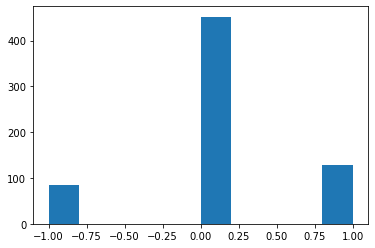

In [176]:
plt.hist(residuals)

**Interpretation**

The residual histogram shows us that the model is predicting more 'AskanAmerican', or 0, than 'AskEurope' or 1. 

This could be because 'AskanAmerican' posts are slightly infavor, albeit with less than 1\% of majority.

In [177]:
tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds).ravel()

print(confusion_matrix(y_test,
                       preds))

[[245  85]
 [129 207]]


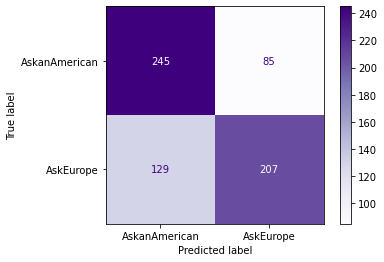

In [178]:
metrics.plot_confusion_matrix(model, X_test, y_test, cmap='Purples', 
                      values_format='d', display_labels=['AskanAmerican', 'AskEurope']);

In [179]:
# Precision: tp / (tp + fp)
print('Precision:', tp/(tp+fp))

# Recall: tp / (tp + fn)
print('Recall:', tp/(tp + fn))

# Accuracy: (tn + tp) / (tn + tp + fn + fp)
print('Accuracy:',(tn + tp) / (tn + tp + fn + fp))

# Specificity: tn / (tn + fp)

print('Specificity:',tn / (tn + fp))

Precision: 0.708904109589041
Recall: 0.6160714285714286
Accuracy: 0.6786786786786787
Specificity: 0.7424242424242424


In [180]:
# feature importance of Extra Trees 

feature_importance_df = pd.DataFrame({'importance':model.feature_importances_,
                                                           'features': X.columns})

feature_importance_df.sort_values('importance', ascending = False).head(10)

,importance,features
130,0.058615,Topic0
74,0.057802,language
113,0.057393,state
2,0.043861,comment_length
28,0.037964,.
4,0.037847,AUX_comment
0,0.035151,num_comments
3,0.034812,question_length
1,0.026628,num_upvotes
8,0.026128,VERB_comment


# Boosting Models

In [181]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy =accuracy_score(y_test, y_pred)
accuracy

0.6306306306306306

In [182]:
# Random Forest model
rfc = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('RFC Train:', rfc.score(X_train, y_train))
print('RFC Test:', rfc.score(X_test, y_test))

# AdaBoost model
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
print('\nABC Train:',abc.score(X_train, y_train))
print('ABC Test:',abc.score(X_test, y_test))

# Gradient Boosting model
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('\nGBC Train:',gbc.score(X_train, y_train))
print('GBC Test:',gbc.score(X_test, y_test))


RFC Train: 1.0
RFC Test: 0.7012012012012012

ABC Train: 0.8233233233233234
ABC Test: 0.6741741741741741

GBC Train: 0.8843843843843844
GBC Test: 0.6981981981981982


**Interpretation**
It looks like Gradient Boosting Classifer has a good medium between overfitting and accuracy where Random Forests are overfitting too much and AdaBoost is overfitting less but has a lower test score and lower training score than Gradient Boost. 

In [183]:
gb_clf = GradientBoostingClassifier(n_estimators=50, max_features=2, max_depth=2)
gb_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Accuracy score (training): 0.723
Accuracy score (test): 0.617


In [184]:
gb_clf = GradientBoostingClassifier(n_estimators=100, max_features=2, max_depth=2)
gb_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Accuracy score (training): 0.773
Accuracy score (test): 0.653


In [185]:
gb_clf = GradientBoostingClassifier(n_estimators=100, max_features=2, max_depth=3)
gb_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (test): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Accuracy score (training): 0.830
Accuracy score (test): 0.662


In [186]:
preds = gb_clf.predict(X_test)

In [187]:
tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds).ravel()

print(confusion_matrix(y_test,
                       preds))

[[231  99]
 [126 210]]


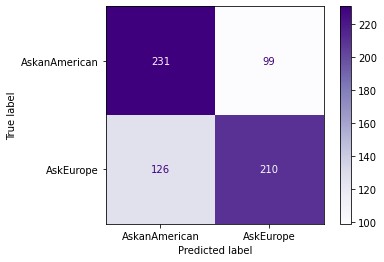

In [188]:
metrics.plot_confusion_matrix(gb_clf, X_test, y_test, cmap='Purples', 
                      values_format='d', display_labels=['AskanAmerican', 'AskEurope']);

In [189]:
# Precision: tp / (tp + fp)
print('Precision:', tp/(tp+fp))

# Recall: tp / (tp + fn)
print('Recall:', tp/(tp + fn))

# Accuracy: (tn + tp) / (tn + tp + fn + fp)
print('Accuracy:',(tn + tp) / (tn + tp + fn + fp))

# Specificity: tn / (tn + fp)

print('Specificity:',tn / (tn + fp))

Precision: 0.6796116504854369
Recall: 0.625
Accuracy: 0.6621621621621622
Specificity: 0.7


**Interpretation**

We can see that this grid search is still overfitting about as much with different parameters and those test scores that are the closest to the training scores are closest to the Decision Tree and Extra Tree Classifiers. 


# Overall Conclusions

Due to the time and cumputational constraint these models are limited by when looking for the best features to give teachers as recommendations, we will make our working model Logistic Regression